<a href="https://colab.research.google.com/github/jefftwebb/MSBA-Capstone/blob/main/EDA_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA with  SQL, Python and R in Google Colab



# 1. Connect to BigQuery, format table display and load R extension.

This interactive authentication requires that you have a google account.

In [ ]:
from google.colab import auth
auth.authenticate_user()

Using Data Table makes it more convenient to navigate tables within the notebook.

In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

 The rpy2 package allows us to write R code.

In [ ]:
%load_ext rpy2.ipython


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# 2. Magic commands to write SQL and R code

Google colab is a web hosted version of a jupityr notebook. Project jupityr started in 2014 with the goal of making  ipython notebooks language agnostic.  Hence jupityr, which stands for "Julia," "Python," and "R." In google colab we can write code chunks in a variety of programming languages in addition to the native Python via the so-called "magic commands."

First: what are magic commands? 

In [ ]:
%magic

Which ones are available? (The R magics only appear after you have loaded the `rpy2` extension.)

In [ ]:
%lsmagic

Available line magics:
%R  %Rdevice  %Rget  %Rpull  %Rpush  %alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %shell  %store  %sx  %system  %tb  %tensorflow_version  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%R  %%SVG  %%bash  %%bigquery  %%capture  %%debug  

Notice that there are two levels of magic commands:

- %% affects the entire cell; 
- % affects an individual line.

In this tutorial we'll be using bigquery magics (to write SQL against tables in bigquery) and R magics (to write R code).

For example, the following cell uses %%bigquery to query the google analytics public dataset, storing the result in a pandas dataframe (the default format in .ipynb) defined in the cell magic statement as "df." **In the code chunks below you will need to replace "project-id" with your own GCP project ID.**

Here for illustration we return 10 rows from the entire dataset for Aug 1, 2017.

In [ ]:
%%bigquery --project capstone-359314 df

SELECT * FROM bigquery-public-data.google_analytics_sample.ga_sessions_20170801
limit 10

In [ ]:
type(df)

pandas.core.frame.DataFrame

In [ ]:
df.shape

(10, 16)

In [ ]:
df.info()


In [ ]:
df.head()

The arrays from BigQuery have been brought into a pandas dataframe as what appear to be JSON columns. These include: totals, trafficSource, device, geoNetwork, and hits. The grain of the data is one row per visit; these latter columns record information within visits, and would need to be aggregated to the visit level to preserve the grain. We won't do that here.

I prefer to do EDA in R, so my ultimate goal is to produce a rectangular dataset that can be read into R for data exploration. However R cannot import the JSON columns (which it interprets as python dicts). To prepare for EDA in R  we need to go back and revise the initial query to flatten the data.

# 3. Flatten Data

For reference, here is a detailed [data dictionary](https://support.google.com/analytics/answer/3437719?hl=en&ref_topic=3416089).

You will most likely want to create different tables as you explore different ideas during EDA.

The goal here is to create a table without nested data, featuring just one row per session. (This entails avoiding the `hits` and `product` tables, for now, since unnesting those will generate multiple rows per session--equivalent to a mutating join.) We will also bring in a month's worth of data. 



In [ ]:
%%bigquery --project capstone-359314 df 

SELECT fullVisitorId, visitId, date,  device.*, totals.*, channelGrouping
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20160831'

In [ ]:
df.shape

(74759, 34)

In [ ]:
df.columns

Index(['fullVisitorId', 'visitId', 'date', 'browser', 'browserVersion',
       'browserSize', 'operatingSystem', 'operatingSystemVersion', 'isMobile',
       'mobileDeviceBranding', 'mobileDeviceModel', 'mobileInputSelector',
       'mobileDeviceInfo', 'mobileDeviceMarketingName', 'flashVersion',
       'javaEnabled', 'language', 'screenColors', 'screenResolution',
       'deviceCategory', 'visits', 'hits', 'pageviews', 'timeOnSite',
       'bounces', 'transactions', 'transactionRevenue', 'newVisits',
       'screenviews', 'uniqueScreenviews', 'timeOnScreen',
       'totalTransactionRevenue', 'sessionQualityDim', 'channelGrouping'],
      dtype='object')

# 4. Import Data into R

We have already loaded the rpy2 package so we can now use R magic commands to load the df dataset into R. (-i stands for "input.")

In [ ]:
%R -i df # Note: %R runs an R line of code in a python code chunk

Load the tidyverse as well as other any other packages you would like to use. Note that you will need to install packages first. 



In [ ]:
%%R # Note: %%R defines an R code chunk

library(tidyverse)



✔ tibble  3.1.7      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 

✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



Inspect the data.

In [ ]:
%R str(df)

'data.frame':	74759 obs. of  34 variables:
 $ fullVisitorId            : chr  "0481273239859840133" "0980222707282431430" "3330357741548094102" "0514860897874035287" ...
 $ visitId                  : int  1471756508 1471722434 1471703492 1471744776 1471709789 1471732019 1471748588 1471717236 1471730048 1471680692 ...
 $ date                     : chr  "20160820" "20160820" "20160820" "20160820" ...
 $ browser                  : chr  "Safari" "Chrome" "Chrome" "Chrome" ...
 $ browserVersion           : chr  "not available in demo dataset" "not available in demo dataset" "not available in demo dataset" "not available in demo dataset" ...
 $ browserSize              : chr  "not available in demo dataset" "not available in demo dataset" "not available in demo dataset" "not available in demo dataset" ...
 $ operatingSystem          : chr  "iOS" "Windows" "Windows" "Windows" ...
 $ operatingSystemVersion   : chr  "not available in demo dataset" "not available in demo dataset" "not available 

Looks good!

# 5. EDA

EDA is an art and a science. There is no one right way to explore a dataset. Use your creativity and critical thinking to explore hypotheses, and to ask and answer questions, based on your knowledge of the business problem and business context.

Assume for now that the target variable for this project will be `transactionRevenue` and that the objective will be either explanatory (what causes purchases?) or predictive (which customers will buy?).  In the latter case we might be interested in predicting future revenue to do targeted marketing.   

To illustrate the exploratory process, let's start with a hypothesis:  higher purchase rates and higher revenue will be associated with more pageviews. The logic would be that customers looking for something -- indicated by higher pageviews-- are more likely to buy. And: the more page view the more motivated the customer probably is and the more likely to buy. Note that there are two targets implied by this hypothesis:

1. Purchase: a binary indicator for whether revenue for a session was greater than 0.
2. Revenue: the amount spent.

In EDA there are always a large number of possible hypotheses and questions, which can feel overwhelming, like looking for a needle in a haystack.  The procedure is to strategically limit exploration by--in this case--thinking about possible drivers of purchasing. 

# EDA Example

Tactics and techniques:
- Investigate errors by looking at individual rows
- Imputation of NAs
- Log transformation for right-skewed and/or zero inflated distributions
- Histograms
- 5 number summary
- Scatterplots
- Smoothing
- Binning
- Boxplots
- Interactions

## Grain of the data 

One preliminary issue is to make sure that the grain of the data is what we expect. One row per visit?

In [ ]:
%%R

df$visitId |> unique() |> length() # calculate number of unique visits using base pipe

[1] 73494


In [ ]:
%%R

df |> nrow() # calculate number of rows

[1] 74759


Not the same.  Arrgh! Row-by-row exploration will be required to understand what is going on.

In [ ]:
%%R 

which(duplicated(df$visitId))[1] # find the first duplicated row

[1] 258


In [ ]:
%R df[258, ] # use the index of the duplicated row to return the row

,fullVisitorId,visitId,date,browser,browserVersion,browserSize,operatingSystem,operatingSystemVersion,isMobile,mobileDeviceBranding,...,bounces,transactions,transactionRevenue,newVisits,screenviews,uniqueScreenviews,timeOnScreen,totalTransactionRevenue,sessionQualityDim,channelGrouping
257,5755318980232615423,1471714460,20160820,Safari,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,0,not available in demo dataset,...,NaN,NaN,NaN,1.0,-2147483648,-2147483648,-2147483648,NaN,-2147483648,Referral


In [ ]:
%%R

df |> filter(visitId == 1471714460) # filter the data by the visitId for the dup row

           fullVisitorId    visitId     date    browser
17   2436244520003187375 1471714460 20160820 UC Browser
257  5755318980232615423 1471714460 20160820     Safari
1334 6666966519764298412 1471714460 20160820     Safari
                    browserVersion                   browserSize
17   not available in demo dataset not available in demo dataset
257  not available in demo dataset not available in demo dataset
1334 not available in demo dataset not available in demo dataset
     operatingSystem        operatingSystemVersion isMobile
17             Linux not available in demo dataset    FALSE
257        Macintosh not available in demo dataset    FALSE
1334       Macintosh not available in demo dataset    FALSE
              mobileDeviceBranding             mobileDeviceModel
17   not available in demo dataset not available in demo dataset
257  not available in demo dataset not available in demo dataset
1334 not available in demo dataset not available in demo dataset
               m

Interesting!  `visitId` is not unique.  However, we can create a unique ID by combining it with `fullVisitorId` and `date` (since a single session seems to be recorded twice by Google Anaytics if it happens to span the change in date from 11:59 PM to 12:00 AM).

In [ ]:
%%R

df <- df |> mutate(unique_id = paste0(fullVisitorId, visitId, date)) # create unique id

In [ ]:
%R df$unique_id |> unique() |> length() # recalculate number of visits

array([74759], dtype=int32)

Now there is one row per unique visit.  

It is worth noting that we could choose to treat a session that occurs over two days not as two sessions, as we've done, but as one session that is arbitrarily split by the clock. This is a data modeling decision, and as such is neither right nor wrong. Keep it in mind though, since we may want to revise it. 

## Distribution of `transactionRevenue`

In [ ]:
%R head(df$transactionRevenue, 1000) # check top of data

Clearly, a session that did not result in a purchase is coded `NaN`.  That should be recoded as 0 and the amount of the purchase should be returned to a legible number by dividing by 10^6. While we're at it, let's copy this column and shorten the name.

In [ ]:
%%R 

df <- df |> 
mutate(rev = transactionRevenue,
       rev = rev/10^6, # transform revenue
       rev = replace_na(rev, 0)) # replace NaNs w 0

In [ ]:
%R head(df$rev, 1000) # check result

Next, visualize the distribution.

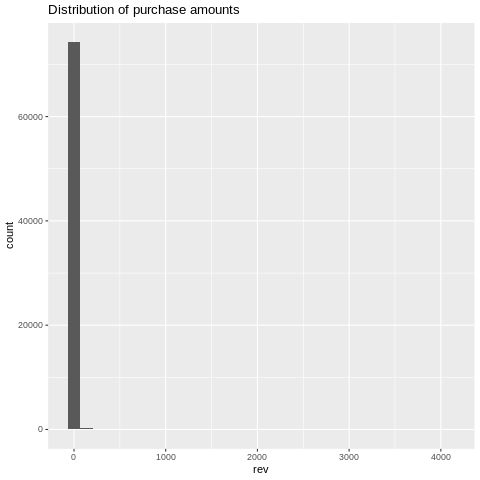

In [ ]:
%%R

# Note that here and in other viz I am not saving an object but just printing

ggplot(data = df, aes(x = rev)) +
geom_histogram() +
labs(title = "Distribution of purchase amounts") # should always include a title


Zero inflated.  Let's take a look at just the distribution of revenue > 0.

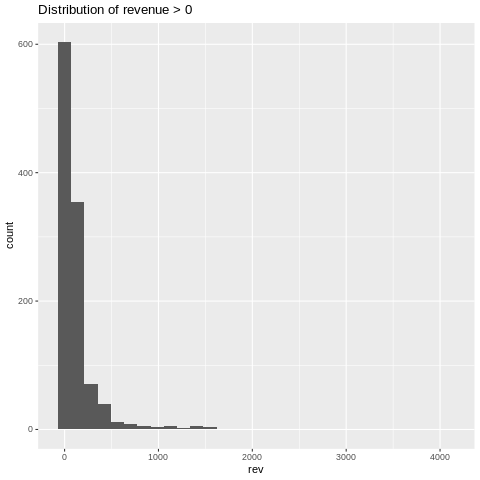

In [ ]:
%%R

df |>
filter(rev > 0) |>
ggplot(aes(rev)) +
geom_histogram() +
labs(title = "Distribution of revenue > 0") 

Check 5 number summary of `rev.`

In [ ]:
%%R

df %>%
filter(rev > 0) %>%
select(rev) %>%
summary


      rev         
 Min.   :   0.01  
 1st Qu.:  31.95  
 Median :  63.15  
 Mean   : 138.22  
 3rd Qu.: 128.00  
 Max.   :4085.50  


Long right tail. Log normal? Looks like it:

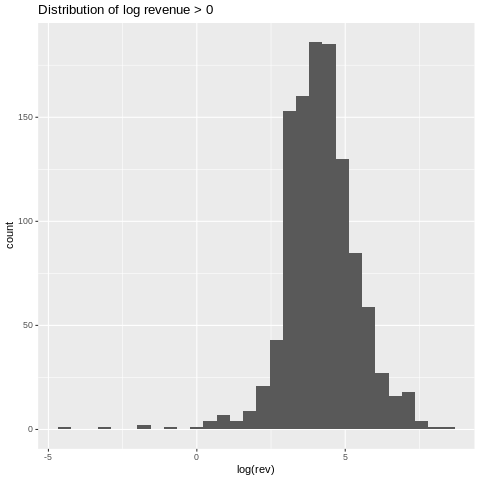

In [ ]:
%%R

df |>
filter(rev > 0) |> # filter rev to be non-zero:  log(0) is undefined
ggplot(aes(log(rev))) + # do log transform w/in ggplot
geom_histogram() +
labs(title = "Distribution of log revenue > 0") 

We may need to log transform `transactionRevenue` for modeling later on, depending on the algorithm.

## Distribution of pageviews

There should be a minimum of 1, since the visit was recorded in Google Analytics.

In [ ]:
%%R
summary(df$pageviews)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  1.000   1.000   2.000   4.848   5.000 469.000      15 


Could look into what an NA might mean (if anything) for pageviews.

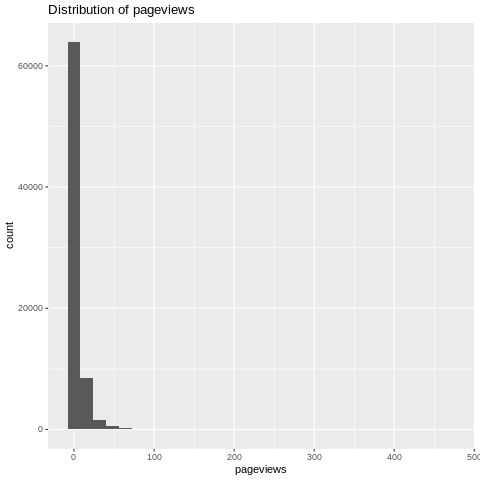

In [ ]:
%%R 

ggplot(df, aes(pageviews)) +
geom_histogram() +
labs(title = "Distribution of pageviews")


Strongly right skewed with large outliers. At least 50% of the customers viewed just one or two pages.

## Are pageviews related to revenue? 

Specifically does the proportion of purchases and related revenue go up with `pageviews`?



**Scatterplots and smoothing**

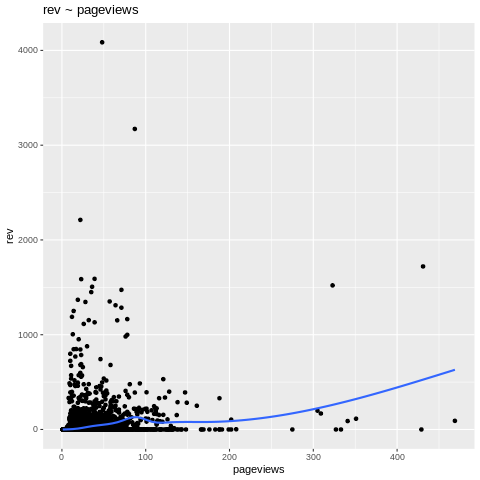

In [ ]:
%%R

ggplot(df, aes(pageviews, rev)) +
geom_point() +
geom_smooth(se = F) + # Uses default LOESS smoothing, good for picking out non-linearity
labs(title = "rev ~ pageviews")

Perhaps there is a positive relationship, but it is hard to tell whether the regression line's upward trend is due to influential points. Let's try a log transformation to reduce the influence of the outliers.

Because `rev` includes 0s we do a `log(x + 1)` transformation, which has a nice property: the former 0s are now 1s, that, after log transformation, are 0s again, since `log(1) = 0`.

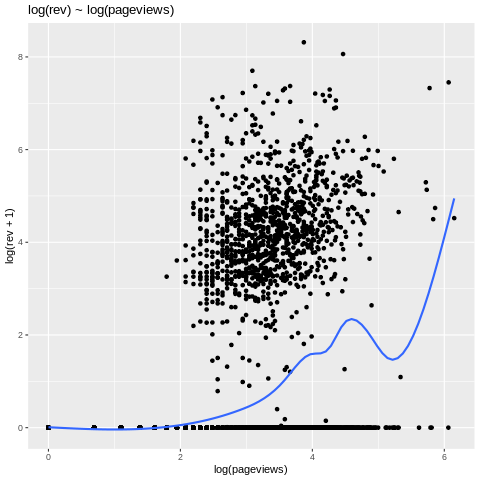

In [ ]:
%%R

ggplot(df, aes(log(pageviews), log(rev + 1))) +
geom_point() +
geom_smooth(se = F) +
labs(title = "log(rev) ~ log(pageviews)")

Same story but still hard to read with the majority of the overplotted points at `log(rev + 1)` = 0.

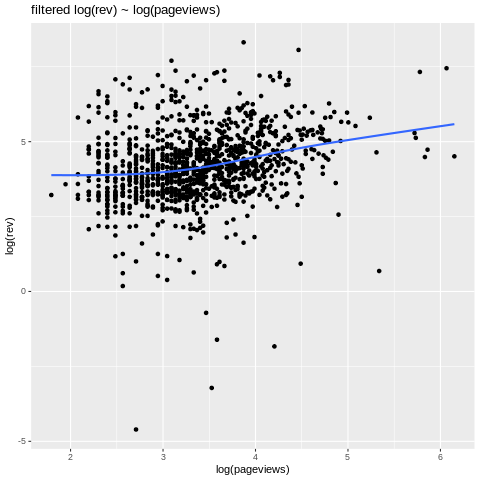

In [ ]:
%%R

df |>
filter(pageviews > 1, rev > 0) |>
ggplot(aes(log(pageviews), log(rev))) +
geom_point() +
geom_smooth(se = F)+
labs(title = "filtered log(rev) ~ log(pageviews)")

**Binning**

Binning is generally very useful for visualization. 

Let's bin `pageviews` and then calculate purchase rate and median purchase amount for each bin.  

Two dpyr functions are helpful to create bins:  `cut_interval()` and `cut_number()`.

`cut_interval()` attempts to make the bin widths the same.

In [1]:
%%R 

df |>
filter(!is.na(pageviews)) |>
mutate(pageview_bins = cut_interval(log(pageviews), 12)) |> # log pageviews to reduce bin width
group_by(pageview_bins) |> # group by bins to produce summary stats for each bin
summarize(n = n(),
          purchase_rate = sum(rev > 0)/n, # calculates the proportion of purchases in each bin
          median_purchase = median(rev[rev > 0])) # calculates the median rev for rev > 0 in bins

UsageError: Cell magic `%%R` not found.


`cut_number()` attempts to put the same number of observations in each bin. It does not work well in this instance because there are so many observations at `pageviews` equal to 1 and 2.

**Boxplots**

Here is a boxplot that shows the pattern from the above table. We could use a barplot to visualize the above summary table but a boxplot is more efficient.

In [ ]:
%%R 

df |>
filter(!is.na(pageviews)) |>
mutate(pageview_bins = cut_interval(log(pageviews), 8)) |> # reduce bin number for visualization
ggplot(aes(pageview_bins, log(rev + 1)))+
geom_boxplot() +
labs(title = "log(rev) ~ binned pageviews")

## Questions beget questions

Strong bivariate relationships should be checked for interactions with a logical third variable.  

Does the relationship between `transactionRevenue` and `pageviews` vary by `channelGrouping`? 

In [ ]:
%%R 

df |>
filter(!is.na(pageviews)) |>
mutate(pageview_bins = cut_interval(log(pageviews), 8)) |>
group_by(pageview_bins, channelGrouping) |> # Group by both factors
summarize(n = n(),
          purchase_rate = sum(rev > 0)/n, 
          median_purchase = median(rev[rev > 0])) |>
          filter(purchase_rate > 0,   # filter for better legibility in visualization
                 n > 50) |> # n > 50 is an arbitrary cutoff
ggplot(aes(pageview_bins, purchase_rate, fill = channelGrouping))  +
geom_col(position = "dodge") +
labs(title = "Purchase rate by pageviews and channels")